In [28]:
# v1: functional and working, feeding in global parameters and element type embedding predicting unity values
# v2: adding positional encoding along with element type embedding and global parameters as input to the LSTM model

# ------------
# Build a PyTorch Dataset & DataLoader for jumper‑unity prediction
# -------------------------------------------

import glob
import os
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

batch_range = range(1,65)

# ------------------------------------------------------------------
# 0.  Set the root folders (EDIT if your paths are different)
# ------------------------------------------------------------------
ROOT = Path(r"C:\Users\cyang\Desktop\Chi\functions\Jumper_ML")
INPUT_GLOB   = str(ROOT / "inputs_*.txt")

# Unity_elements_{batch}_{model}.txt

# ------------------------------------------------------------------
# 1.  Small helpers
# ------------------------------------------------------------------
def read_inputs_file(path: Path) -> np.ndarray:
    """Return a (N, 32) float array of global inputs *and* the file's batch-id."""
    batch_id = int(path.stem.split("_")[1])          # 'inputs_12.txt' -> 12
    status_dir = ROOT / f"Abaqus_files_{batch_id}\\model_status.txt"


    rows = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.split()
            rows.append([float(x) for x in parts[0:32]])   # skip model_name
    return batch_id, np.asarray(rows, dtype=np.float32)


def read_unity_file(path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Return (elem_type_ids [L], unity_long [L], unity_comb [L])
    """
    et, ul, uc = [], [], []
    with open(path, "r") as f:
        for row in f:
            if not row.strip():
                continue
            cols = row.split()
            # Map element type strings to integer codes
            elem_type = 0 if cols[0] == "PIPE31H" else 1  # PIPE31H -> 0, ELBOW31 -> 1
            et.append(elem_type)
            ul.append(float(cols[1]))
            uc.append(float(cols[2]))
        # print(et)
    return (np.asarray(et, dtype=np.int64),
            np.asarray(ul, dtype=np.float32),
            np.asarray(uc, dtype=np.float32))


# ------------------------------------------------------------------
# 2.  Build memory‑light index of every run(model)
# ------------------------------------------------------------------
class RunIndex:
    """Maps an integer idx -> (global_input, elem_type[], position[], unity_targets[])"""

    def __init__(self):
        self.globals:   List[np.ndarray] = []
        self.positions: List[np.ndarray] = []
        self.elemtypes: List[np.ndarray] = []
        self.targets:   List[np.ndarray] = []

        for batch_id in batch_range:
            in_path = ROOT / f"inputs_{batch_id}.txt"
            batch_id, g_matrix = read_inputs_file(Path(in_path))
            n_models = g_matrix.shape[0]

            for m_idx in range(n_models):
                ELEM_DIR   = ROOT / f"Abaqus_files_{batch_id}\\Step2\\elements"
                unity_path = ELEM_DIR / f"Unity_elements_{batch_id}_{m_idx+1}.txt"
                if not unity_path.exists():
                    continue

                et, ul, uc = read_unity_file(unity_path)
                tgt = np.stack([ul, uc], axis=1)  # (L, 2)
                L = tgt.shape[0]
                pos = (np.arange(L) / L).astype(np.float32)  # normalize position to [0, 1)

                self.globals.append(g_matrix[m_idx])
                self.elemtypes.append(et)
                self.positions.append(pos)
                self.targets.append(tgt)

    def __len__(self):
        return len(self.globals)

    def __getitem__(self, idx: int):
        return (
            self.globals[idx],   # (32,)
            self.elemtypes[idx], # (L,)
            self.positions[idx], # (L,)
            self.targets[idx],   # (L, 2)
        )


# ------------------------------------------------------------------
# 3.  Convert RunIndex into a torch Dataset
# ------------------------------------------------------------------
class JumperDataset(Dataset):
    def __init__(self, run_index: RunIndex):
        self.ri = run_index

    def __len__(self):
        return len(self.ri)

    def __getitem__(self, idx):
        g, et, pos, tgt = self.ri[idx]
        return (
            torch.from_numpy(g),                      # (32,)
            torch.from_numpy(et),                     # (L,)
            torch.from_numpy(pos),                    # (L,)
            torch.from_numpy(tgt),                    # (L, 2)
            torch.tensor(len(et), dtype=torch.long),  # scalar
        )


# ------------------------------------------------------------------
# 4.  collate_fn  → pads to L_max and builds length tensor
# ------------------------------------------------------------------
def collate_fn(batch):
    g_list, et_list, pos_list, tgt_list, len_list = zip(*batch)
    L_max = max(l.item() for l in len_list)

    B = len(batch)
    et_pad  = torch.zeros((B, L_max), dtype=torch.long)
    pos_pad = torch.zeros((B, L_max), dtype=torch.float32)
    tgt_pad = torch.zeros((B, L_max, 2), dtype=torch.float32)

    for i, (et, pos, tgt) in enumerate(zip(et_list, pos_list, tgt_list)):
        L = et.shape[0]
        et_pad[i, :L]  = et
        pos_pad[i, :L] = pos
        tgt_pad[i, :L, :] = tgt

    g_batch = torch.stack(g_list, dim=0)       # (B, 32)
    lengths = torch.stack(len_list, dim=0)     # (B,)

    return g_batch, et_pad, pos_pad, tgt_pad, lengths


# ------------------------------------------------------------------
# 5.  Usage example
# ------------------------------------------------------------------
if __name__ == "__main__":
    runs = RunIndex()
    ds = JumperDataset(runs)
    dl = DataLoader(ds,
                    batch_size=16,
                    shuffle=True,
                    num_workers=0,
                    collate_fn=collate_fn)

    # quick sanity check
    for g, et, pos, tgt, lengths in dl:
        print(f"globals   : {g.shape}")        # (B, 32)
        print(f"elem_type : {et.shape}")       # (B, L_max)
        print(f"positions : {pos.shape}")      # (B, L_max)
        print(f"targets   : {tgt.shape}")      # (B, L_max, 2)
        print(f"lengths   : {lengths}")        # (B,)
        break



globals   : torch.Size([16, 32])
elem_type : torch.Size([16, 569])
positions : torch.Size([16, 569])
targets   : torch.Size([16, 569, 2])
lengths   : tensor([230, 234, 171, 273, 569, 307, 317, 138, 135, 287, 395, 149, 229, 317,
        399, 131])


In [29]:
def find_model_in_runindex(run_index: RunIndex, batch_id: int, model_idx: int):
    """
    Find a specific model in the RunIndex by batch_id and model_idx.
    Returns (idx, global_inputs, elem_types, positions, targets)
    """
    try:
        in_path = ROOT / f"inputs_{batch_id}.txt"
        _, g_matrix = read_inputs_file(Path(in_path))
        target_global = g_matrix[model_idx - 1]  # model_idx is 1-based

        for idx in range(len(run_index)):
            global_inputs, elem_types, positions, targets = run_index[idx]
            if np.array_equal(global_inputs, target_global):
                return idx, global_inputs, elem_types, positions, targets

        print(f"Model with batch_id={batch_id}, model_idx={model_idx} not found in RunIndex")
        return None, None, None, None, None
    except Exception as e:
        print(f"Error finding model: {e}")
        return None, None, None, None, None


if __name__ == "__main__":

    ds = JumperDataset(runs)
    dl = DataLoader(ds,
                    batch_size=16,
                    shuffle=True,
                    num_workers=0,
                    collate_fn=collate_fn)

    # Quick sanity check
    for g, et, pos, tgt, lengths in dl:
        print(f"globals   : {g.shape}")        # (B, 32)
        print(f"elem_type : {et.shape}")       # (B, L_max)
        print(f"positions : {pos.shape}")      # (B, L_max)
        print(f"targets   : {tgt.shape}")      # (B, L_max, 2)
        print(f"lengths   : {lengths}")        # (B,)
        break

    # Inspect a specific model by batch and index
    idx, g, et, pos, tgt = find_model_in_runindex(runs, batch_id=1, model_idx=2)

    if idx is not None:
        g_tensor = torch.from_numpy(g)
        et_tensor = torch.from_numpy(et)
        pos_tensor = torch.from_numpy(pos)
        tgt_tensor = torch.from_numpy(tgt)
        length_tensor = torch.tensor(len(et), dtype=torch.long)

        print("\nAs tensors (exact data used in model):")
        print(f"  Global tensor shape : {g_tensor.shape}")
        print(f"  First 5 global values: {g_tensor[:5]}")
        print(f"  Element types        : {et_tensor[:10]}...")
        print(f"  Positions            : {pos_tensor[:10]}...")
        print(f"  Targets              : {tgt_tensor[:5]}")
        print(f"  Sequence length      : {length_tensor}")


globals   : torch.Size([16, 32])
elem_type : torch.Size([16, 557])
positions : torch.Size([16, 557])
targets   : torch.Size([16, 557, 2])
lengths   : tensor([557, 444, 194, 330, 502, 152, 472, 336, 232, 178, 191, 356, 269, 200,
        139, 155])

As tensors (exact data used in model):
  Global tensor shape : torch.Size([32])
  First 5 global values: tensor([37.9266, 16.1336, 42.4533, 55.3202, 43.2435])
  Element types        : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])...
  Positions            : tensor([0.0000, 0.0055, 0.0109, 0.0164, 0.0219, 0.0273, 0.0328, 0.0383, 0.0437,
        0.0492])...
  Targets              : tensor([[0.3574, 0.4606],
        [0.3480, 0.4541],
        [0.3387, 0.4477],
        [0.3293, 0.4414],
        [0.3200, 0.4352]])
  Sequence length      : 183


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

def analyze_runindex_data(run_index):
    """
    Analyze the RunIndex to count how many models came from each batch.
    Prints a table with batch IDs and corresponding model counts.
    """
    batch_cache = {}   # batch_id -> list of global vectors (ndarray)
    batch_counts = {}  # batch_id -> count of matched models

    total_models = len(run_index)

    print("Indexing input files by batch...")
    for batch_id in batch_range:  # Adjust range if needed
        try:
            in_path = ROOT / f"inputs_{batch_id}.txt"
            _, g_matrix = read_inputs_file(Path(in_path))
            batch_cache[batch_id] = g_matrix
        except FileNotFoundError:
            continue

    print("Matching models to their source batch...")
    for idx in range(total_models):
        g = run_index.globals[idx]
        matched = False
        for batch_id, g_matrix in batch_cache.items():
            if any(np.array_equal(g, row) for row in g_matrix):
                batch_counts[batch_id] = batch_counts.get(batch_id, 0) + 1
                matched = True
                break
        if not matched:
            print(f"Warning: Model #{idx} not matched to any known batch.")

    # Format into DataFrame
    df = pd.DataFrame({
        "Batch ID": list(batch_counts.keys()),
        "Number of Models": list(batch_counts.values())
    }).sort_values(by="Batch ID")

    print("\n Dataset Model Analysis (from RunIndex):")
    print(df.to_string(index=False))
    print(f"\nTotal number of models in dataset: {total_models}")

    return batch_counts, total_models

# Example usage:
batch_counts, total = analyze_runindex_data(runs)


Indexing input files by batch...
Matching models to their source batch...


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 64
EMBED_DIM = 16
HIDDEN_DIM = 256
NUM_LAYERS = 3
DROPOUT = 0.2
LR = 3e-4
EPOCHS = 100
PATIENCE = 10

# ------------------------
# Model definition updated
# ------------------------
class UnityBiLSTM(nn.Module):
    def __init__(self, n_elem_types: int, n_globals: int = 32):
        super().__init__()
        self.elem_embed = nn.Embedding(n_elem_types, EMBED_DIM, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=EMBED_DIM + n_globals + 1,  # +1 for position
            hidden_size=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            batch_first=True,
            bidirectional=True,
            dropout=DROPOUT if NUM_LAYERS > 1 else 0.0,
        )

        self.head = nn.Sequential(
            nn.Linear(HIDDEN_DIM * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, g, et, pos, lengths):
        """
        g    : (B, 32)          global inputs (standardized)
        et   : (B, L)           element type IDs
        pos  : (B, L)           relative position in [0, 1)
        """
        B, L = et.shape

        et_emb = self.elem_embed(et)               # (B, L, EMBED_DIM)
        g_rep  = g.unsqueeze(1).expand(-1, L, -1)   # (B, L, 32)
        pos    = pos.unsqueeze(-1)                 # (B, L, 1)

        x = torch.cat([et_emb, g_rep, pos], dim=-1)  # (B, L, EMBED + 32 + 1)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        h, _ = nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True, total_length=L
        )
        return self.head(h)

# ------------------------
# Masked MSE loss
# ------------------------
def masked_mse(pred, target, lengths):
    mask = (torch.arange(target.size(1), device=lengths.device)[None, :] < lengths[:, None]).unsqueeze(-1)
    return ((pred - target) ** 2 * mask).sum() / mask.sum()

# ------------------------
# Data preparation
# ------------------------
runs = RunIndex()

# Normalize global features (in-place)
g_stack = np.stack(runs.globals, axis=0)
global_mean = g_stack.mean(axis=0)
global_std = g_stack.std(axis=0)
global_std[global_std == 0] = 1.0  # Avoid divide-by-zero

for i in range(len(runs)):
    runs.globals[i] = (runs.globals[i] - global_mean) / global_std

# Save for inference
np.save("global_mean.npy", global_mean)
np.save("global_std.npy", global_std)

# Dataset and loaders
ds = JumperDataset(runs)
val_size = int(len(ds) * 0.1)
train_size = len(ds) - val_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory=True)

N_ELEM_TYPES = max([et.max() for et in runs.elemtypes]) + 1

# ------------------------
# Training loop with early stopping
# ------------------------
model = UnityBiLSTM(n_elem_types=N_ELEM_TYPES, n_globals=32).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for g, et, pos, tgt, lengths in train_dl:
        g, et, pos, tgt, lengths = g.to(DEVICE), et.to(DEVICE), pos.to(DEVICE), tgt.to(DEVICE), lengths.to(DEVICE)

        opt.zero_grad()
        y_hat = model(g, et, pos, lengths)
        loss = masked_mse(y_hat, tgt, lengths)
        loss.backward()
        opt.step()

        train_loss += loss.item()
    train_loss /= len(train_dl)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for g, et, pos, tgt, lengths in val_dl:
            g, et, pos, tgt, lengths = g.to(DEVICE), et.to(DEVICE), pos.to(DEVICE), tgt.to(DEVICE), lengths.to(DEVICE)
            y_hat = model(g, et, pos, lengths)
            loss = masked_mse(y_hat, tgt, lengths)
            val_loss += loss.item()
    val_loss /= len(val_dl)

    print(f"Epoch {epoch:02d}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_unity_bilstm.pt")
        print("  --> Val loss improved, saving model.")
    else:
        epochs_no_improve += 1
        print(f"  --> No improvement ({epochs_no_improve}/{PATIENCE})")

    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Training complete.")


Using device: cuda
Epoch 01: Train loss = 0.7022, Val loss = 0.2692
  --> Val loss improved, saving model.
Epoch 02: Train loss = 0.2445, Val loss = 0.1799
  --> Val loss improved, saving model.
Epoch 03: Train loss = 0.2094, Val loss = 0.1745
  --> Val loss improved, saving model.
Epoch 04: Train loss = 0.2017, Val loss = 0.1684
  --> Val loss improved, saving model.
Epoch 05: Train loss = 0.1920, Val loss = 0.1632
  --> Val loss improved, saving model.
Epoch 06: Train loss = 0.1804, Val loss = 0.1560
  --> Val loss improved, saving model.
Epoch 07: Train loss = 0.1762, Val loss = 0.1641
  --> No improvement (1/10)
Epoch 08: Train loss = 0.1629, Val loss = 0.1381
  --> Val loss improved, saving model.
Epoch 09: Train loss = 0.1466, Val loss = 0.1313
  --> Val loss improved, saving model.
Epoch 10: Train loss = 0.1382, Val loss = 0.1237
  --> Val loss improved, saving model.
Epoch 11: Train loss = 0.1295, Val loss = 0.1160
  --> Val loss improved, saving model.
Epoch 12: Train loss = 0

In [ ]:
MODEL_PATH = "unity_bilstm_v2.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to unity_bilstm_v2.pt


In [26]:
import numpy as np
from typing import List
import torch

PIPE, ELBOW = 0, 1  # consistent with training labels

def build_elem_types(seg_lengths: List[float],
                     outer_diameter: float,
                     bend_angle_rad: float = np.pi / 2,
                     bend_radius_factor: float = 5.0,
                     min_pipe_elements: int = 1) -> np.ndarray:
    H = outer_diameter
    R = bend_radius_factor * outer_diameter
    L_bend = R * bend_angle_rad
    n_elbow = max(1, int(np.ceil(L_bend / H)))
    actual_L_bend = n_elbow * H  # actual length covered by elbow elements

    types = []
    num_segments = len(seg_lengths)

    for k, Lseg in enumerate(seg_lengths):
        num_bends = 1/2 if (k == 0 or k == num_segments - 1) else 1

        available_pipe_length = Lseg - num_bends * 10*H

        # If too short, force a minimal straight section of at least 1 pipe element
        if available_pipe_length < H * min_pipe_elements:
            n_pipe = min_pipe_elements
        else:
            n_pipe = int(np.ceil(available_pipe_length / H))

        types.extend([PIPE] * n_pipe)
        if k != num_segments - 1:
            types.extend([ELBOW] * n_elbow)

    return np.asarray(types, dtype=np.int64)




DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_FILE = "unity_bilstm_v2.pt"

# -------- Load raw input (unstandardized) ----------
g_raw = np.array([28.89045, 14.46195, 20.23866, 70.89006, 19.33562, 14.46195,
                  44.69494, 43.41846, 170.3305, 2623.41446, 1061784.706, 0.10417,
                  1.33333, 19, -0.125, 0.125, 0.125, 0.00873, 0.01745, 0,
                  0.125, 0.125, -0.125, -0.00873, -0.01745, 0,
                  3.28873, 1.4538, 3.15864, -2.18767, 0.44241, -1.93973], dtype=np.float32)

assert g_raw.size == 32

# -------- Standardize input for model inference ----------
global_mean = np.load("global_mean.npy")
global_std  = np.load("global_std.npy")
g_std = (g_raw - global_mean) / global_std   # standardized version used only for model input

# -------- Use original values to compute mesh layout ----------
seg_len = g_raw[:7]      # real segment lengths in meters
outer_d = g_raw[12]      # real OD in meters

elem_type = build_elem_types(seg_len, outer_d)
L = elem_type.size

# -------- Create position vector ----------
positions = (np.arange(L) / L).astype(np.float32)

# -------- Load model ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_FILE = "unity_bilstm_v2.pt"
runs = RunIndex()
n_typ = max(et.max() for et in runs.elemtypes) + 1
model = UnityBiLSTM(n_typ, n_globals=32).to(DEVICE)
model.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
model.eval()

# -------- Convert inputs to tensors ----------
g_tensor  = torch.from_numpy(g_std).unsqueeze(0).to(DEVICE)         # (1, 32)
et_tensor = torch.from_numpy(elem_type).unsqueeze(0).to(DEVICE)     # (1, L)
pos_tensor = torch.from_numpy(positions).unsqueeze(0).to(DEVICE)    # (1, L)
lengths   = torch.tensor([L], dtype=torch.long).to(DEVICE)

# -------- Predict ----------
with torch.no_grad():
    y_hat = model(g_tensor, et_tensor, pos_tensor, lengths)

pred = y_hat[0, :L].cpu().numpy()
unity_long, unity_comb = pred[:, 0], pred[:, 1]

# -------- Output results ----------
print(f"\nGenerated {L} elements (OD={outer_d:.3f}, total pipe length={seg_len.sum():.1f} m)\n")
print(" idx │ elem_type │ unity_long │ unity_comb")
print("─────┼───────────┼────────────┼────────────")
for i in range(L):
    et_label = "PIPE" if elem_type[i] == 0 else "ELBOW"
    print(f"{i:4d} │ {et_label:^9} │ {unity_long[i]:10.4f} │ {unity_comb[i]:10.4f}")



Generated 151 elements (OD=1.333, total pipe length=213.0 m)

 idx │ elem_type │ unity_long │ unity_comb
─────┼───────────┼────────────┼────────────
   0 │   PIPE    │     0.5204 │     0.7895
   1 │   PIPE    │     0.5071 │     0.7959
   2 │   PIPE    │     0.4963 │     0.7887
   3 │   PIPE    │     0.4977 │     0.7884
   4 │   PIPE    │     0.4969 │     0.7861
   5 │   PIPE    │     0.4943 │     0.7847
   6 │   PIPE    │     0.4909 │     0.7823
   7 │   PIPE    │     0.4906 │     0.7802
   8 │   PIPE    │     0.4941 │     0.7788
   9 │   PIPE    │     0.5015 │     0.7784
  10 │   PIPE    │     0.5140 │     0.7797
  11 │   PIPE    │     0.5323 │     0.7864
  12 │   PIPE    │     0.5603 │     0.8065
  13 │   PIPE    │     0.5873 │     0.8337
  14 │   PIPE    │     0.6106 │     0.8613
  15 │   PIPE    │     0.6391 │     0.8926
  16 │   PIPE    │     0.6798 │     0.9341
  17 │   ELBOW   │     0.7436 │     1.0008
  18 │   ELBOW   │     0.7917 │     1.0437
  19 │   ELBOW   │     0.8328 │  

In [90]:
print(max(unity_long))
print(max(unity_comb))


0.6671339
0.7705864


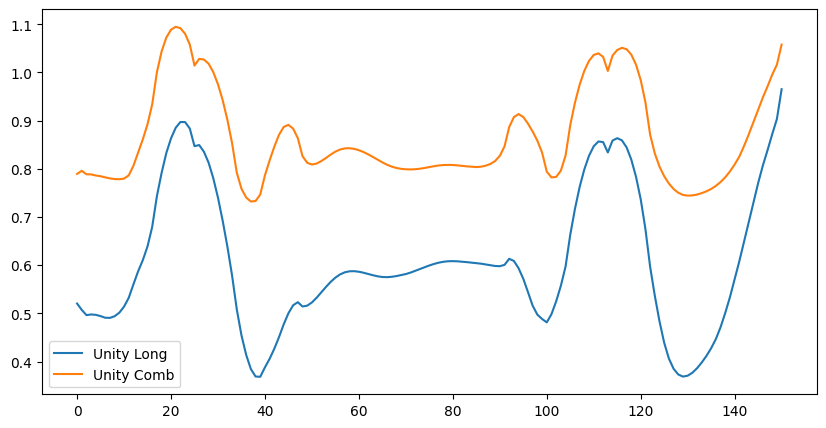

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(unity_long, label='Unity Long')
plt.plot(unity_comb, label='Unity Comb')
plt.legend()
plt.show()